# Import Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import string   # generate alphabet
import random   # randomly create substitution cipher
import re       # for string operations
import requests
import os
import textwrap

# Generate Cipher

In [2]:
alphabet_key = list(string.ascii_lowercase)
alphabet_val = list(string.ascii_lowercase)
random.shuffle(alphabet_val)
true_map = {}

# generate the answer
for k, v in zip(alphabet_key, alphabet_val):
    true_map[k] = v

# Helper Functions

In [3]:
# Markov Assumption: the probability of char's occurence is based on the previous letter
# Not the best but simple to kickstart

# Potential Upgrade
    # Higher grams, e.g. trigrams with bigrams & unigram (25 x 25 x 25)
    # Replace Markov model with Deep Learning RNN



# Initialize Matrix for storing bigram (letters after first letter) probabilities in Markov model (probability of each letter corresponds to each letter)
M_bi = np.ones((26,26))

# Initialize Matrix for storing unigram (first letter of each word) probabilities in Markov model
M_uni = np.zeros(26)

# remove non-alpha characters
regex = re.compile('[^a-zA-Z]')

# update occurance of bigram
def update_matrix(char1, char2=None):    
    # normalize to start from 0 by offsetting to ord('a')
    i = ord(char1) - ord('a')
    if char2 is not None:
        j = ord(char2) - ord('a')
        M_bi[i,j] += 1
    else:
        M_uni[i] += 1 

# get log probability of a word
# log probability avoid probabilities getting rounded to 0 when multiplications happen
def get_word_prob(word):
    i = ord(word[0]) - ord('a')
    log_prob = np.log(M_uni[i])
    for char in word[1:]:
        j = ord(char) - ord('a')
        log_prob += np.log(M_bi[i,j])
        i = j
    return log_prob

def get_sentence_prob(words):
    if type(words) == str:
        words = words.split()
    log_prob = 0
    for word in words:
        log_prob += get_word_prob(word)
    return log_prob

In [4]:
def encode_message(msg):
    msg = msg.lower()
    msg = regex.sub(' ', msg)

    encoded_msg = []
    for char in msg:
        if char in true_map:
            encoded_char = true_map[char]
        else:
            encoded_char = char     # whitespaces
        encoded_msg.append(encoded_char)

    return ''.join(encoded_msg)

In [5]:
def decode_msg(msg, decode_map):
    decoded_msg = []
    for char in msg:
        if char in decode_map:
            decoded_char = decode_map[char]
        else:
            decoded_char = char     # whitespaces
        decoded_msg.append(decoded_char)

    return ''.join(decoded_msg)

In [6]:
def evolve_cipher(cipher_pool, n_child):
    evolved_cipher = []

    for cipher in cipher_pool:
        for _ in range(n_child):

            #initialize child cipher
            child = cipher.copy()
            
            # intitalize swapping for two letters in cipher map
            idx_1 = np.random.randint(len(child))
            idx_2 = np.random.randint(len(child))

            # swap
            tmp = child[idx_1]
            child[idx_1] = child[idx_2]
            child[idx_2] = tmp
            evolved_cipher.append(child)

    return evolved_cipher + cipher_pool

# Load Data

Train Set

In [7]:
if not os.path.exists('moby_dick.txt'):
    r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
    with open('moby_dick.txt','w') as f:
        f.write(r.content.decode())     # decode byte array to string & save it into file

Test Set

In [8]:
# Extracted from http://www.gutenberg.org/files/1661/1661-h/1661-h.htm
ori_message = 'To Sherlock Holmes she is always the woman. I have seldom heard him mention her under any other name. In his eyes she eclipses and predominates the whole of her sex. It was not that he felt any emotion akin to love for Irene Adler. All emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind. He was, I take it, the most perfect reasoning and observing machine that the world has seen, but as a lover he would have placed himself in a false position. He never spoke of the softer passions, save with a gibe and a sneer. They were admirable things for the observer—excellent for drawing the veil from men’s motives and actions. But for the trained reasoner to admit such intrusions into his own delicate and finely adjusted temperament was to introduce a distracting factor which might throw a doubt upon all his mental results. Grit in a sensitive instrument, or a crack in one of his own high-power lenses, would not be more disturbing than a strong emotion in a nature such as his. And yet there was but one woman to him, and that woman was the late Irene Adler, of dubious and questionable memory.'

# '''I then lounged down the street and found,
# as I expected, that there was a mews in a lane which runs down
# by one wall of the garden. I lent the ostlers a hand in rubbing
# down their horses, and received in exchange twopence, a glass of
# half-and-half, two fills of shag tobacco, and as much information
# as I could desire about Miss Adler, to say nothing of half a dozen
# other people in the neighbourhood in whom I was not in the least
# interested, but whose biographies I was compelled to listen to.
# '''

# Away they went, and I was just wondering whether I should not do well
# to follow them when up the lane came a neat little landau, the coachman
# with his coat only half-buttoned, and his tie under his ear, while all
# the tags of his harness were sticking out of the buckles. It hadn't
# pulled up before she shot out of the hall door and into it. I only
# caught a glimpse of her at the moment, but she was a lovely woman, with
# a face that a man might die for.

# My cabby drove fast. I don't think I ever drove faster, but the others
# were there before us. The cab and the landau with their steaming horses
# were in front of the door when I arrived. I paid the man and hurried
# into the church. There was not a soul there save the two whom I had
# followed and a surpliced clergyman, who seemed to be expostulating with
# them. They were all three standing in a knot in front of the altar. I
# lounged up the side aisle like any other idler who has dropped into a
# church. Suddenly, to my surprise, the three at the altar faced round to
# me, and Godfrey Norton came running as hard as he could towards me.

In [9]:
encoded_msg = encode_message(ori_message)

# Train Model

In [10]:
# Train decryption model using paragraphs in Moby Dick 
# with open('moby_dick.txt','r') as f:
for line in open('moby_dick.txt'):      
    line = line.rstrip()        # strip out white spaces  
    # blank line is ignored
    if line:
        line = regex.sub(' ', line)     # replace non-alpha characters with space
        tokens = line.lower().split()   # split line into word tokens & convert capital letters to small letter
        for token in tokens:
            # convert alpha chars to digit representations
            char_0 = token[0]
            update_matrix(char_0)
            for char_1 in token[1:]:
                update_matrix(char_0, char_1)
                char_0 = char_1
                
# Normalization
M_bi /= M_bi.sum(axis=1, keepdims=True)
M_uni /= M_uni.sum()

# Decryption

In [11]:
# Cipher Initialization
cipher_pool = []
for _ in range(20):
    cipher = list(string.ascii_lowercase)
    random.shuffle(cipher)
    cipher_pool.append(cipher)

In [12]:
NUM_ITERS = 601
scores = np.zeros(NUM_ITERS)
best_cipher = None
best_map = None
best_score = float('-inf')

for i in range(NUM_ITERS):
    if i > 0:
         cipher_pool = evolve_cipher(cipher_pool, 3)

    cipher_score = {}
    for cipher in cipher_pool:
        current_map = {}
        for k, v in zip(alphabet_key, cipher):
            current_map[k] = v

        decoded_msg = decode_msg(encoded_msg, current_map)
        score = get_sentence_prob(decoded_msg)

        cipher_score[''.join(cipher)] = score

        if score > best_score:
            best_cipher = cipher
            best_map = current_map
            best_score = score

    # store average score of cipher child in for this generation
    scores[i] = np.mean(list(cipher_score.values()))

    # sort cipher by score and keep only top 5
    sorted_score = sorted(cipher_score.items(), key=lambda x: x[1], reverse=True)
    cipher_pool = [list(k) for k, v in sorted_score[:5]]

    # print progression checkpoint for every 200 iterations
    if i % 200 == 0:
        print(f"iter: {i}, score: {scores[i]}, best score: {best_score}")

iter: 0, score: -4996.986102907476, best score: -4383.217822546761
iter: 200, score: -2565.145438855536, best score: -2249.2885341810484
iter: 400, score: -2444.7907027026417, best score: -2169.4222231132926
iter: 600, score: -2362.3794003352714, best score: -2169.4222231132926


# Evaluation

In [13]:
decoded_msg = decode_msg(encoded_msg, best_map)

In [14]:
# Log Likelihood comparison
ll_ori = get_sentence_prob(regex.sub(' ', ori_message.lower()))
ll_decoded = get_sentence_prob(decoded_msg)
ll_err_perc = abs((ll_decoded - ll_ori) / ll_ori) * 100
print("LL - decoded  message:", ll_decoded)
print("LL - original message:", ll_ori)
print(f"Error Perc : {ll_err_perc:.2f}%")

LL - decoded  message: -2169.4222231132926
LL - original message: -2169.4222231132926
Error Perc : 0.00%


In [15]:
ori_message

'To Sherlock Holmes she is always the woman. I have seldom heard him mention her under any other name. In his eyes she eclipses and predominates the whole of her sex. It was not that he felt any emotion akin to love for Irene Adler. All emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind. He was, I take it, the most perfect reasoning and observing machine that the world has seen, but as a lover he would have placed himself in a false position. He never spoke of the softer passions, save with a gibe and a sneer. They were admirable things for the observer—excellent for drawing the veil from men’s motives and actions. But for the trained reasoner to admit such intrusions into his own delicate and finely adjusted temperament was to introduce a distracting factor which might throw a doubt upon all his mental results. Grit in a sensitive instrument, or a crack in one of his own high-power lenses, would not be more disturbing than a strong emo

In [16]:
encoded_msg

'dk xloaekmj lkeuox xlo wx sefsqx dlo fkush  w lsto xoeyku losay lwu uohdwkh loa rhyoa shq kdloa hsuo  wh lwx oqox xlo omewgxox shy gaoykuwhsdox dlo flkeo kc loa xov  wd fsx hkd dlsd lo coed shq oukdwkh sjwh dk ekto cka waoho syeoa  see oukdwkhx  shy dlsd kho gsadwmresaeq  foao splkaaohd dk lwx mkey  gaomwxo prd syuwaspeq pseshmoy uwhy  lo fsx  w dsjo wd  dlo ukxd goacomd aosxkhwhb shy kpxoatwhb usmlwho dlsd dlo fkaey lsx xooh  prd sx s ektoa lo fkrey lsto gesmoy lwuxoec wh s csexo gkxwdwkh  lo hotoa xgkjo kc dlo xkcdoa gsxxwkhx  xsto fwdl s bwpo shy s xhooa  dloq foao syuwaspeo dlwhbx cka dlo kpxoatoa ovmoeeohd cka yasfwhb dlo towe caku uoh x ukdwtox shy smdwkhx  prd cka dlo daswhoy aosxkhoa dk syuwd xrml whdarxwkhx whdk lwx kfh yoewmsdo shy cwhoeq syirxdoy dougoasuohd fsx dk whdakyrmo s ywxdasmdwhb csmdka flwml uwbld dlakf s ykrpd rgkh see lwx uohdse aoxredx  bawd wh s xohxwdwto whxdaruohd  ka s masmj wh kho kc lwx kfh lwbl gkfoa eohxox  fkrey hkd po ukao ywxdrapwhb dlsh s xdakhb ouk

In [17]:
decoded_msg

'to sherlock holmes she is always the woman  i have seldom heard him mention her under any other name  in his eyes she eclipses and predominates the whole of her sex  it was not that he felt any emotion akin to love for irene adler  all emotions  and that one particularly  were abhorrent to his cold  precise but admirably balanced mind  he was  i take it  the most perfect reasoning and observing machine that the world has seen  but as a lover he would have placed himself in a false position  he never spoke of the softer passions  save with a gibe and a sneer  they were admirable things for the observer excellent for drawing the veil from men s motives and actions  but for the trained reasoner to admit such intrusions into his own delicate and finely adjusted temperament was to introduce a distracting factor which might throw a doubt upon all his mental results  grit in a sensitive instrument  or a crack in one of his own high power lenses  would not be more disturbing than a strong emo

In [20]:
# Check incorrect letter(s)?
for ori, v in true_map.items():
  pred = best_map[v]
  if ori != pred:
    print(f"ori: {ori}, pred: {pred}")

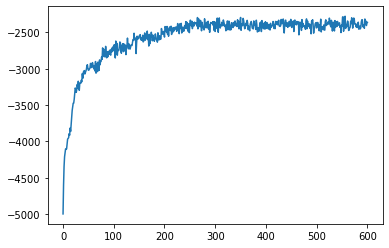

In [18]:
plt.plot(scores);
plt.show();